# Maximal Update Parametrization (μP) - coordinate checking

The purpose of this notebook is to illustrate the correctness of the μP implementation. This is done by calculating the average size of coordinates for a few training steps across the varying model widths for (a) pre-activation layers, (b) model weights, and (c) changes in model weights.

In [1]:
import math
from collections.abc import Callable
from typing import Literal

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

from cellarium.ml.layers import MuLinear
from cellarium.ml.utilities.testing import get_coord_data

## Data processing

The models are trained on CIFAR-10 dataset.

In [2]:
data_dir = "/tmp"
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


## Model definitions
A simple 2-hidden-layer MLP with SP and muP. Notice that at base width Standard and μ Parametrizatons are identical. MLP with SP is given in [1].

In [3]:
# SP MLP
class MLP(nn.Module):
    def __init__(self, width=128, num_classes=10, bias=False, nonlin=F.relu, input_mult=1.0, output_mult=1.0):
        super().__init__()
        self.nonlin = nonlin
        self.bias = bias
        self.input_mult = input_mult
        self.output_mult = output_mult
        self.fc_1 = nn.Linear(3072, width, bias=bias)
        self.fc_2 = nn.Linear(width, width, bias=bias)
        self.fc_3 = nn.Linear(width, num_classes, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        fan_in_1 = self.fc_1.weight.shape[1]
        nn.init.normal_(self.fc_1.weight, std=1 / math.sqrt(fan_in_1))  # 1 / sqrt(d)
        self.fc_1.weight.data /= self.input_mult**0.5
        fan_in_2 = self.fc_2.weight.shape[1]
        nn.init.normal_(self.fc_2.weight, std=1 / math.sqrt(fan_in_2))  # 1 / sqrt(n)
        nn.init.zeros_(self.fc_3.weight)  # zero readout
        if self.bias:
            # zero biases
            nn.init.zeros_(self.fc_1.bias)
            nn.init.zeros_(self.fc_2.bias)
            nn.init.zeros_(self.fc_3.bias)

    def forward(self, x):
        x = self.nonlin(self.fc_1(x) * self.input_mult**0.5)
        x = self.nonlin(self.fc_2(x))
        return self.fc_3(x) * self.output_mult


# muP MLP
class MuMLP(nn.Module):
    def __init__(
        self, width=128, num_classes=10, bias=False, nonlin=F.relu, optimizer="sgd", input_mult=1.0, output_mult=1.0
    ):
        super().__init__()
        self.nonlin = nonlin
        self.input_mult = input_mult
        self.output_mult = output_mult
        self.fc_1 = MuLinear(
            in_features=3072,
            out_features=width,
            bias=bias,
            layer="input",
            optimizer=optimizer,
            weight_init_std=(1 / math.sqrt(3072 * self.input_mult)),
            base_width=128,
        )
        self.fc_2 = MuLinear(
            in_features=width,
            out_features=width,
            bias=bias,
            layer="hidden",
            optimizer=optimizer,
            weight_init_std=(1 / math.sqrt(128)),
            base_width=128,
        )
        self.fc_3 = MuLinear(
            in_features=width,
            out_features=num_classes,
            bias=bias,
            layer="output",
            optimizer=optimizer,
            weight_init_std=0.0,
            base_width=128,
        )

    def forward(self, x):
        x = self.nonlin(self.fc_1(x) * self.input_mult**0.5)
        x = self.nonlin(self.fc_2(x))
        return self.fc_3(x) * self.output_mult

## Checking coordinate statistics

Following are the scaling rules for μP (Appendix J.2 of [1]):
- Pre-activation layers (outputs): $\Theta(1)$
- Input weights: $W = \Theta(1)$ and $\Delta W = \Theta(1)$
- Hidden weights: $W = \Theta(1 / \sqrt{n})$ and $\Delta W = \Theta(1 / n)$
- Output weights: $W = \Theta(1 / n)$ and $\Delta W = \Theta(1 / n)$
- All biases: $b = \Theta(1)$ and $\Delta b = \Theta(1)$

In [4]:
optim_dict = {"sgd": torch.optim.SGD, "adam": torch.optim.Adam, "adamw": torch.optim.AdamW}


# adapted from https://github.com/microsoft/mup/blob/main/examples/MLP/main.py
def coord_check_MLP(
    mup: bool,
    bias: bool,
    nonlin: Callable[[torch.Tensor], torch.Tensor],
    lr: float,
    input_mult: float,
    output_mult: float,
    optim_name: Literal["sgd", "adam", "adamw"],
    train_loader: torch.utils.data.DataLoader,
    nsteps: int,
    nseeds: int,
    widths: list[int],
) -> None:
    def gen(w: int) -> Callable[[], nn.Module]:
        def f() -> nn.Module:
            model: nn.Module
            if mup:
                model = MuMLP(
                    width=w,
                    bias=bias,
                    nonlin=nonlin,
                    optimizer=optim_name,
                    input_mult=input_mult,
                    output_mult=output_mult,
                )
            else:
                model = MLP(width=w, bias=bias, nonlin=nonlin, input_mult=input_mult, output_mult=output_mult)
            return model

        return f

    models = {w: gen(w) for w in widths}
    optim_fn = optim_dict[optim_name]
    df = get_coord_data(
        models, train_loader, loss_fn=F.cross_entropy, lr=lr, optim_fn=optim_fn, nsteps=nsteps, nseeds=nseeds
    )

    # plot coordinates
    fig = plt.figure(figsize=(5 * nsteps, 10 + bias * 6))
    face_color = "xkcd:light grey" if not mup else None
    if face_color is not None:
        fig.patch.set_facecolor(face_color)
    n_rows = 3 + bias * 2
    for t in range(nsteps):
        df_t = df[df.t == t]
        # outputs
        plt.subplot(n_rows, nsteps, t + 1)
        sns.lineplot(x="width", y="l1", data=df_t[(df_t.type == "out")], hue="module", legend=True if t == 0 else None)
        plt.title(f"t={t}")
        if t != 0:
            plt.ylabel("")
        plt.loglog(base=2, nonpositive="mask")

        # parameter values
        plt.subplot(n_rows, nsteps, t + 1 + nsteps)
        sns.lineplot(
            x="width",
            y="l1",
            data=df_t[(df_t.type == "param") & (df_t.module.str.contains("weight"))],
            hue="module",
            legend=True if t == 0 else None,
        )
        if t != 0:
            plt.ylabel("")
        plt.loglog(base=2, nonpositive="mask")

        # parameter deltas
        plt.subplot(n_rows, nsteps, t + 1 + nsteps * 2)
        sns.lineplot(
            x="width",
            y="l1",
            data=df_t[(df_t.type == "delta") & (df_t.module.str.contains("weight"))],
            hue="module",
            legend=True if t == 0 else None,
        )
        if t != 0:
            plt.ylabel("")
        plt.loglog(base=2, nonpositive="mask")

        if bias:
            # bias values
            plt.subplot(n_rows, nsteps, t + 1 + nsteps * 3)
            sns.lineplot(
                x="width",
                y="l1",
                data=df_t[(df_t.type == "param") & (df_t.module.str.contains("bias"))],
                hue="module",
                legend=True if t == 0 else None,
            )
            if t != 0:
                plt.ylabel("")
            plt.loglog(base=2, nonpositive="mask")

            # bias deltas
            plt.subplot(n_rows, nsteps, t + 1 + nsteps * 4)
            sns.lineplot(
                x="width",
                y="l1",
                data=df_t[(df_t.type == "delta") & (df_t.module.str.contains("bias"))],
                hue="module",
                legend=True if t == 0 else None,
            )
            if t != 0:
                plt.ylabel("")
            plt.loglog(base=2, nonpositive="mask")
    prm = "μP" if mup else "SP"
    suptitle = f"{prm} MLP {optim_name} lr={lr} nseeds={nseeds}"
    plt.suptitle(suptitle)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

μP implementations differ for different optimizers, therefore, we have to check each optimizer separately.

### Illustrating correctness of the μP implementation for the SGD optimizer

Notice how for the μP MLP coordinates scale with width according to the rules above at each time step. In particular, layer outputs are constant and do not explode with width.

In [5]:
# optimal values for HPs at base width for SGD optimizer
# input_mult = 2**-8
# output_mult = 2**5

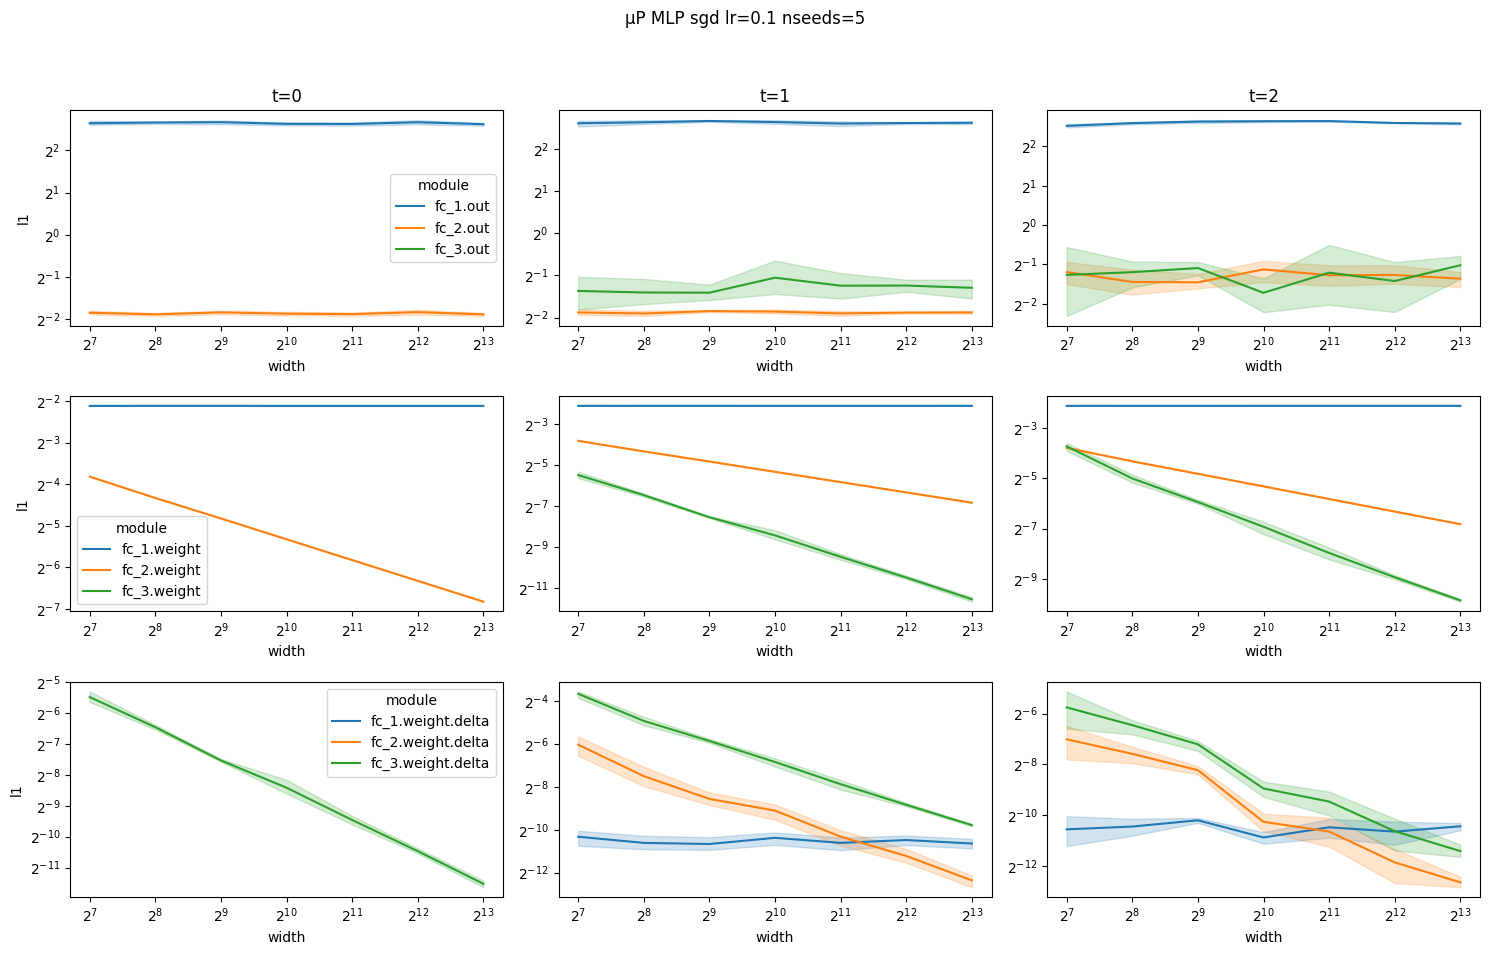

In [6]:
# muP SGD
coord_check_MLP(
    mup=True,
    bias=False,
    nonlin=F.relu,
    lr=0.1,
    input_mult=2**-8,
    output_mult=2**5,
    optim_name="sgd",
    train_loader=train_loader,
    nsteps=3,
    nseeds=5,
    widths=[2**i for i in range(7, 14)],
)

Now, notice how for SP MLP the layer outputs explode with width at time steps 1 and 2.

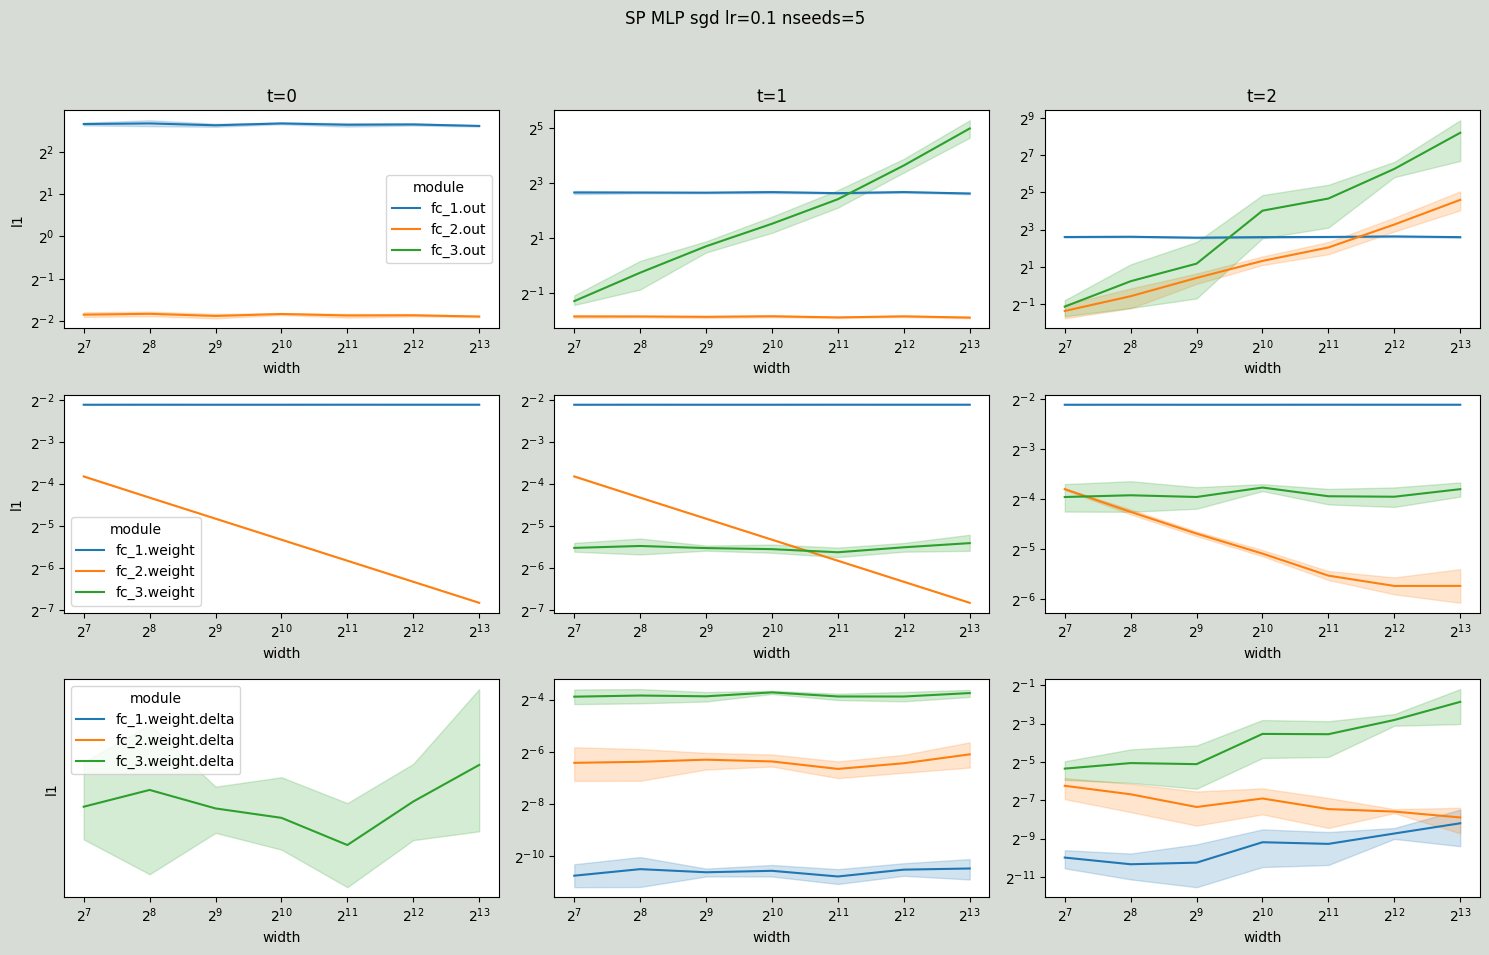

In [7]:
# SP SGD
coord_check_MLP(
    mup=False,
    bias=False,
    nonlin=F.relu,
    lr=0.1,
    input_mult=2**-8,
    output_mult=2**5,
    optim_name="sgd",
    train_loader=train_loader,
    nsteps=3,
    nseeds=5,
    widths=[2**i for i in range(7, 14)],
)

### Illustrating correctness of the μP implementation for the Adam optimizer

Again, notice how coordinates scale according to the μP scaling rules.

In [12]:
# optimal values for HPs at base width for Adam optimizer
# input_mult = 2**-6
# output_mult = 2**-4

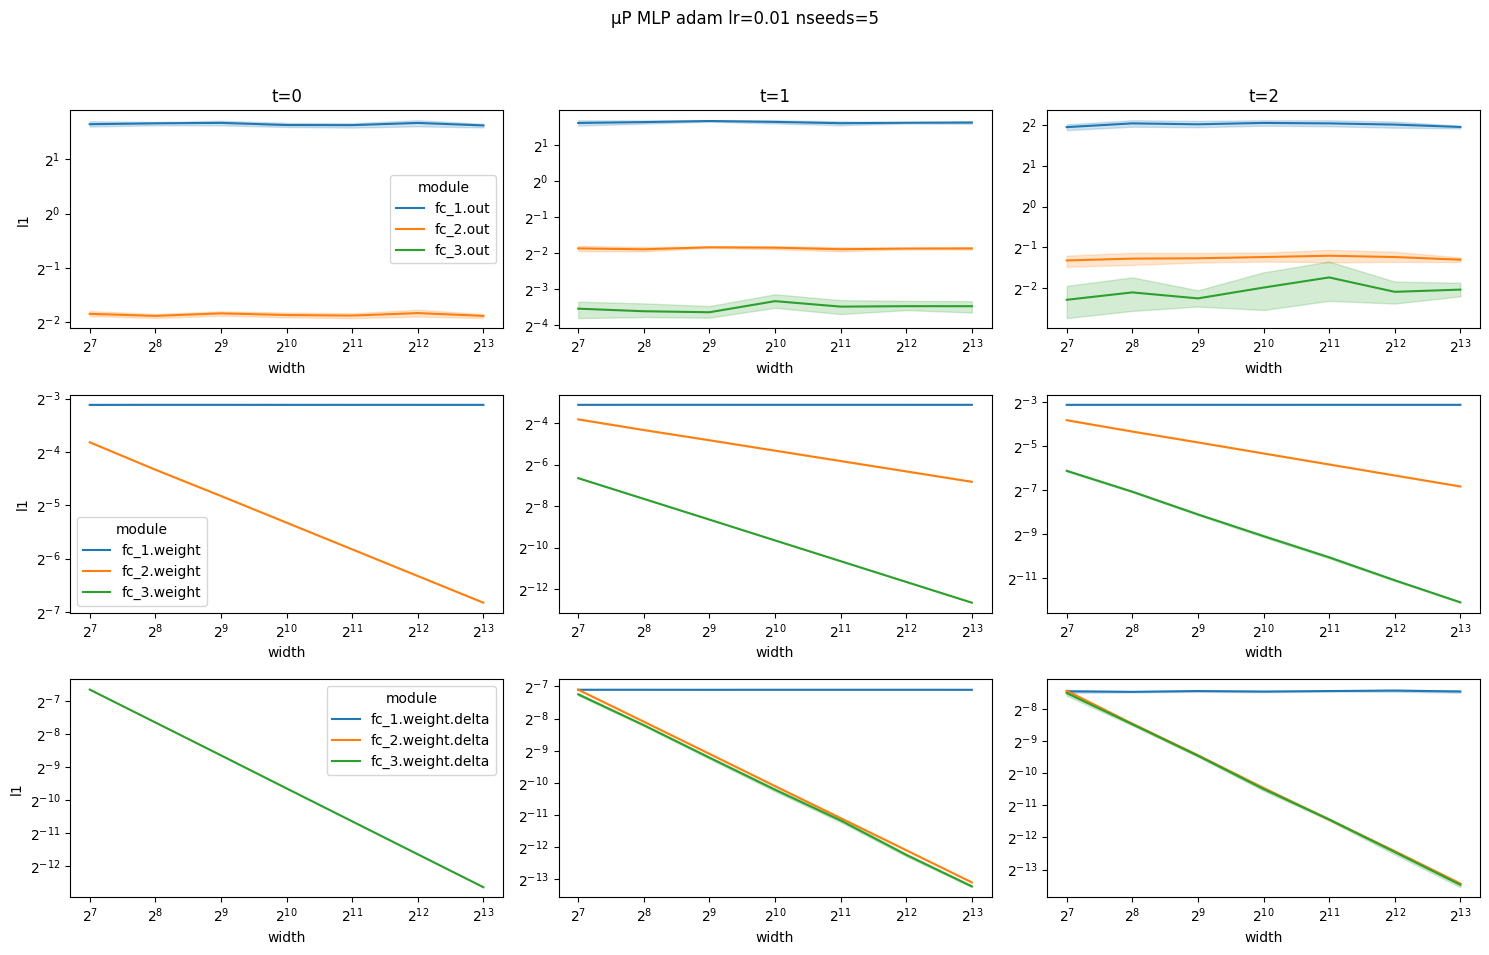

In [8]:
# muP Adam
coord_check_MLP(
    mup=True,
    bias=False,
    nonlin=F.relu,
    lr=0.01,
    input_mult=2**-6,
    output_mult=2**-4,
    optim_name="adam",
    train_loader=train_loader,
    nsteps=3,
    nseeds=5,
    widths=[2**i for i in range(7, 14)],
)

And layer outputs explode at time steps 1 and 2 for SP MLP.

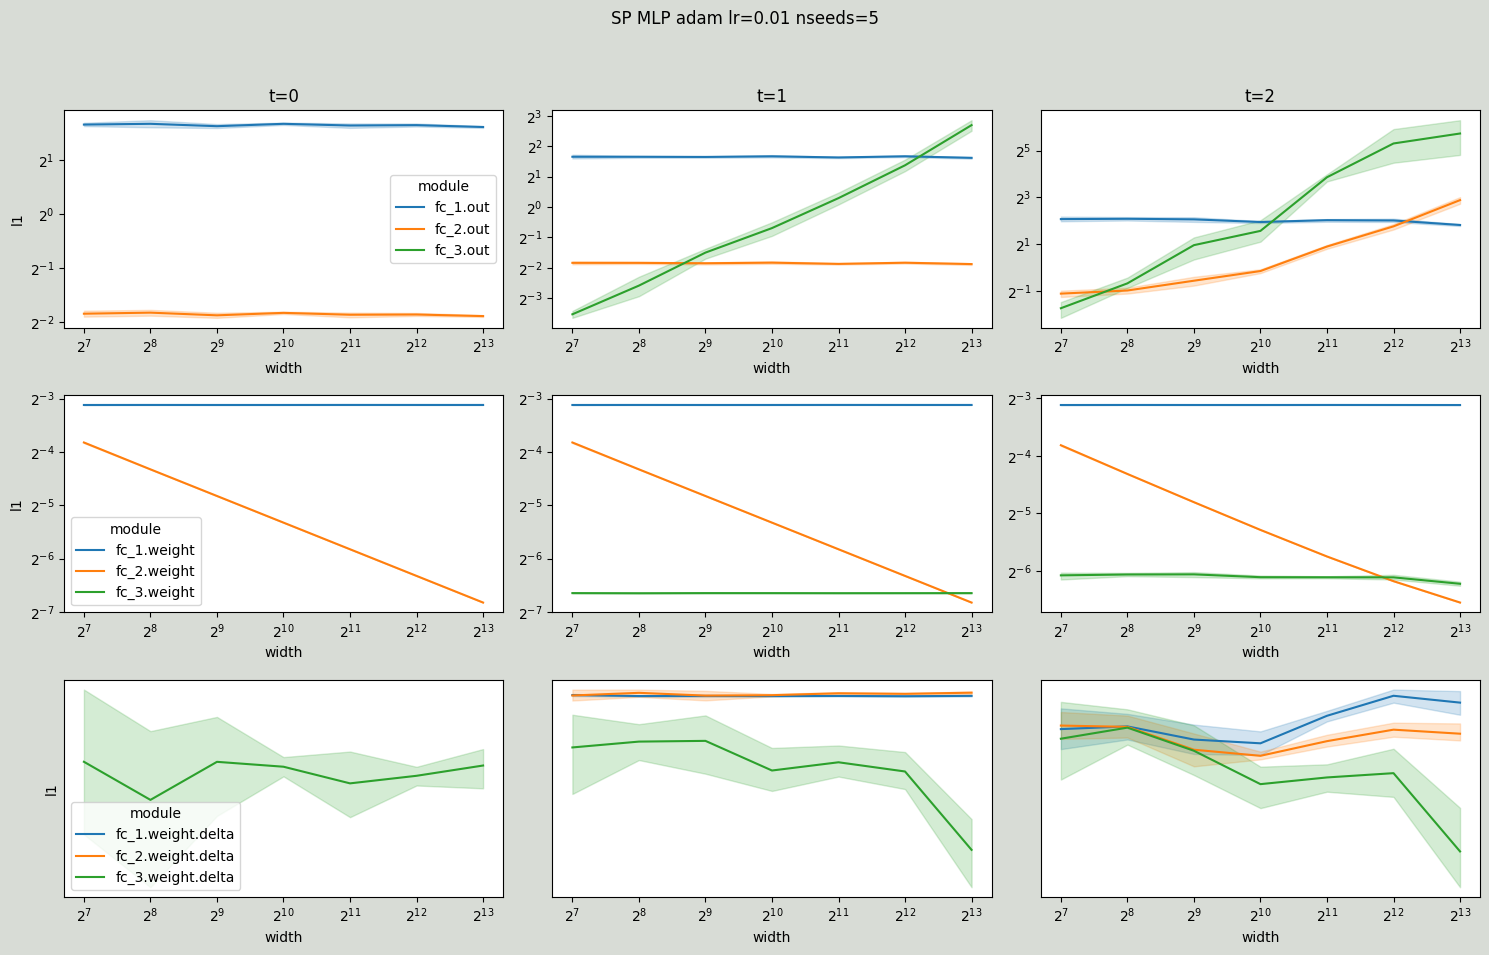

In [9]:
# SP Adam
coord_check_MLP(
    mup=False,
    bias=False,
    nonlin=F.relu,
    lr=0.01,
    input_mult=2**-6,
    output_mult=2**-4,
    optim_name="adam",
    train_loader=train_loader,
    nsteps=3,
    nseeds=5,
    widths=[2**i for i in range(7, 14)],
)

### Illustrating correctness of the μP implementation for the AdamW optimizer

Same scaling rules apply for AdamW with one exception: for hidden layer weights ∆W is a combination of gradient updates Θ(1/n) and weight decay Θ(1/sqrt(n)) that scale differently. In particular, at time step 0 ∆W is only due to weight decay Θ(1/sqrt(n)) and at time steps 1 and 2 ∆W is dominated by the weight decay Θ(1/sqrt(n)).

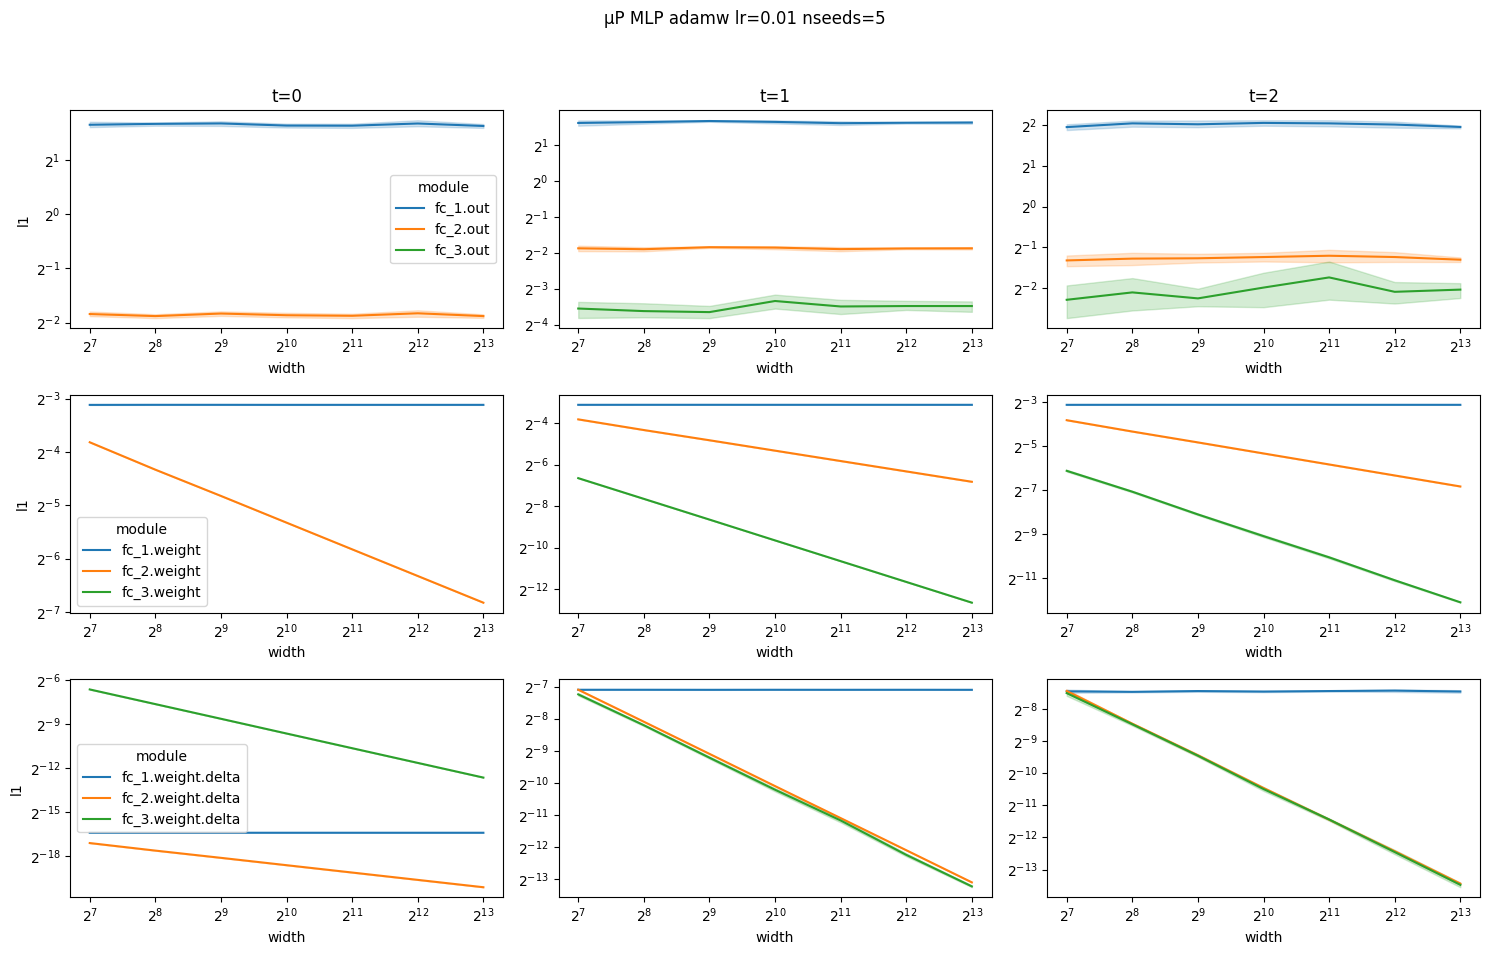

In [10]:
# muP AdamW
coord_check_MLP(
    mup=True,
    bias=False,
    nonlin=F.relu,
    lr=0.01,
    input_mult=2**-6,
    output_mult=2**-4,
    optim_name="adamw",
    train_loader=train_loader,
    nsteps=3,
    nseeds=5,
    widths=[2**i for i in range(7, 14)],
)

Again, for comparison SP MLP with exploding layer outputs.

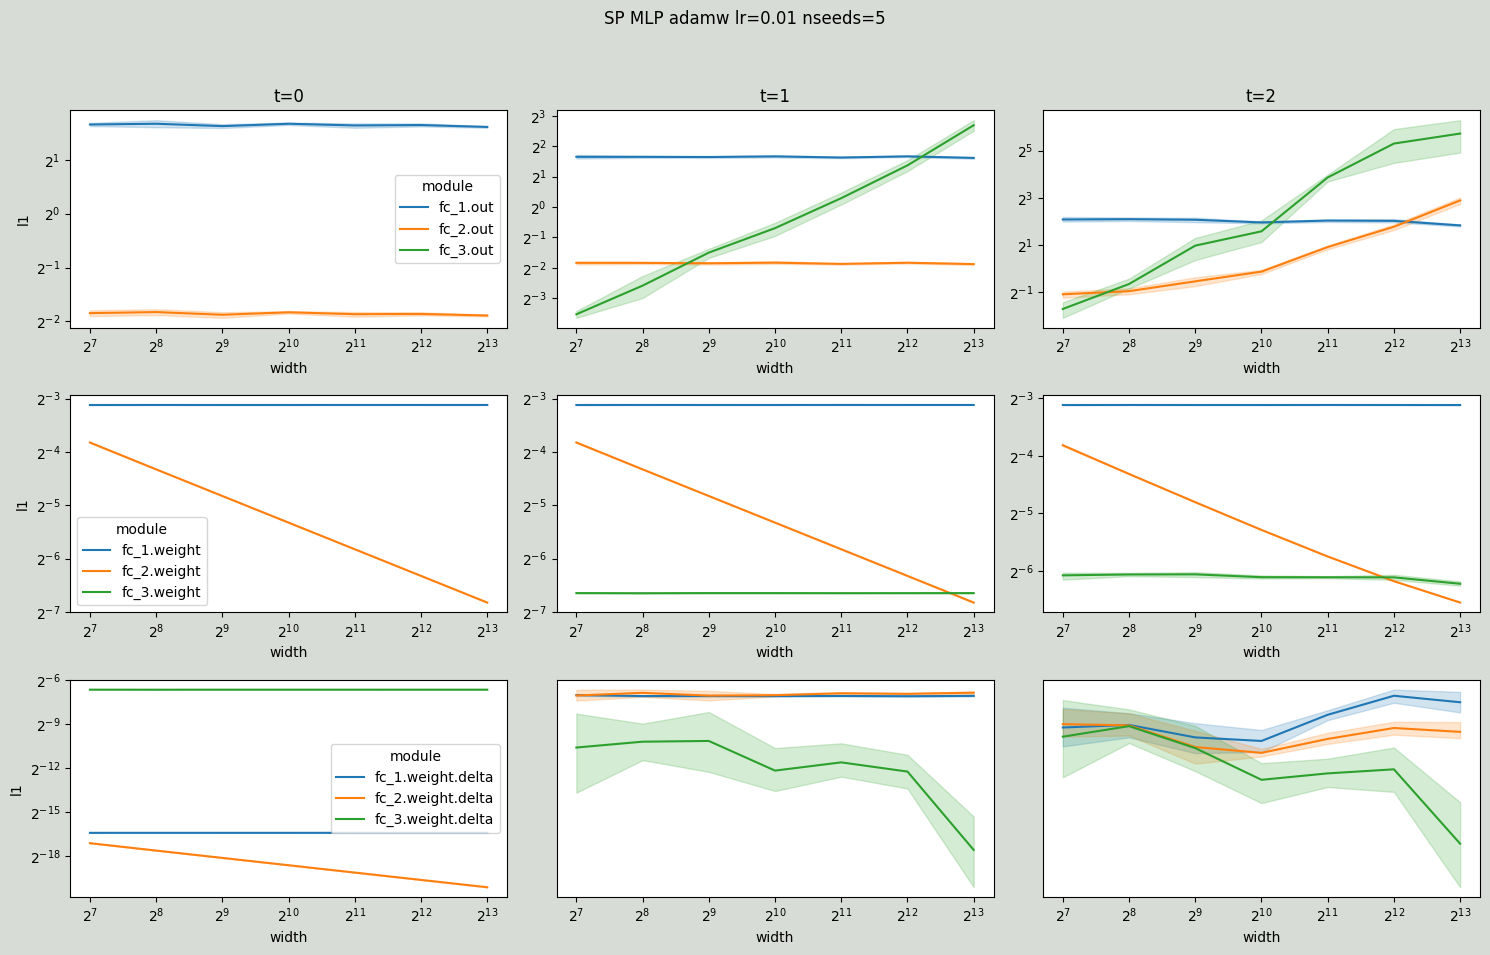

In [11]:
# SP AdamW
coord_check_MLP(
    mup=False,
    bias=False,
    nonlin=F.relu,
    lr=0.01,
    input_mult=2**-6,
    output_mult=2**-4,
    optim_name="adamw",
    train_loader=train_loader,
    nsteps=3,
    nseeds=5,
    widths=[2**i for i in range(7, 14)],
)

References:

1. [Tensor Programs V: Tuning Large Neural Networks via Zero-Shot Hyperparameter Transfer (Yang et al.)](https://arxiv.org/abs/2203.03466.pdf)